# A TUTORIAL ON GAUSSIAN PROCESSES FOR OPTIMIZATION

by Sebastian T. Glavind, Dec, 2021

In [1]:
import numpy as np
import math
import GPy
import sklearn.gaussian_process
import scipy.stats as stats
import scipy.special as ssp
import seaborn as sns
import pandas as pd
import pickle
import warnings
from matplotlib import pyplot as plt
%matplotlib inline

# Gaussian process-based Bayesian optimization

In this tutorial, we consider the problem of finding a global minimizer of a function $f$ defined by covariate(s) $\mathbf{x}$:

$$
\mathbf{x}_{\min} = \text{arg} \min_{\mathbf{x} \in \mathbf{X}} f(\mathbf{x}).
$$

Bayesian optimization (BO) is a sequential model-based approach for optimizing an objective function, which is computationally expensive to evaluate, and/or has no closed-form expression, but from which we can obtain (noisy) observations. BO techniques are some of the most efficient optimization techniques in terms of number of functional evaluations required, due to their use of Bayesian updating:

$$
p(f|\mathcal{D}) \propto p(\mathcal{D}|f) p(f), \nonumber
$$

where $\mathcal{D} = \{ \hat{\mathbf{X}}, \hat{\mathbf{y}} \} =  \{ \mathbf{x}[n], y[n] \}_{n=1}^N$ is a data set of observations of the objective function. 

Bayesian optimization using Gaussian processes (GPs) leverage Bayes rule to build a surrogate model of the objective function (validation loss) with a prior over functions and combine it with new observations to form a posterior over functions, in an online fashion. This permits a utility-based selection of the next point to sample from the objective function, which should account for the trade-off between exploration (sampling from areas of high uncertainty) and exploitation (sampling from areas that are likely to provide an improvement over the current best setting $\mathbf{x}_{\min}^{(t)}$). Thus, we assume $f$ to be a non-linear, non-parametric function with a GP prior:

$$
f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')),
$$

where $m(\mathbf{x}) = \mathbb{E}[f(\mathbf{x})]$ is the expected value function, and $k(\mathbf{x},\mathbf{x}') = \text{cov}[f(\mathbf{x}), f(\mathbf{x}')]$ is the positive definite covariance or kernel function.

Given a data set, the GP prior is established by evaluating the expected value and covariance functions at the data points, which leads to a multivariate Gaussian distribution over the corresponding function values:

$$
f(\hat{\mathbf{X}}) \sim \mathcal{N}(m(\hat{\mathbf{X}}),k(\hat{\mathbf{X}},\hat{\mathbf{X}})).
$$

Under proper normalization of the data, the expected value of the process can be assumed to be zero without loss of generality, and the kernel function should then capture basic aspects of the process, such as stationarity, isotropicity, smoothness, and periodicity.

Under a Gaussian noise assumption, the output observations $\hat{\mathbf{y}}$ and the functional evaluation $f(\mathbf{x_{\star}})$ at a new test point $\mathbf{x_{\star}}$ are jointly Gaussian, and by application of the standard rules for conditioning of Gaussian distributed random variables, we arrive at a closed-form expression for the predictive distribution of $f(\mathbf{x}_{\star})$:

$$    
p(f(\mathbf{x}_{\star})|\mathcal{D},\mathbf{x}_{\star}, \boldsymbol\Theta) = \mathcal{N}(f_{\star}(\mathbf{x}_{\star}), k_{\star}(\mathbf{x}_{\star}, \mathbf{x}_{\star}) ),
$$

where $ \boldsymbol\Theta$ denotes the set of model parameters, and $f_{\star}$ and $k_{\star}$ are defined as:

$$
     f_{\star}(\mathbf{x}_{\star}) = \mathbf{k}_{\mathbf{x}_{\star}} (k(\hat{\mathbf{X}}, \hat{\mathbf{X}}) + \sigma^2\mathbf{I} )^{-1} \hat{\mathbf{y}}
$$

$$
k_{\star}(\mathbf{x}_{\star}, \mathbf{x}_{\star}) = k(\mathbf{x}_{\star},\mathbf{x}_{\star}) - \mathbf{k}_{\mathbf{x}_{\star}} (k(\hat{\mathbf{X}}, \hat{\mathbf{X}}) + \sigma^2\mathbf{I} )^{-1} \mathbf{k}_{\mathbf{x}_{\star}}^T,
$$

with $\mathbf{k}_{\mathbf{x}_{\star}}$ as a shorthand notation for $k(\mathbf{x}_{\star}, \hat{\mathbf{X}})$, and $\mathbf{I}$ is the identity matrix. Note that if we are interested in the corresponding noisy prediction $y_{\star}$, we simply have to add $\sigma^2$ to the predictive variance expression above. See e.g., Rasmussen(2006) and Bishop(2006) for further details on GPs, and their training.

In order to conduct a utility-based selection of the next point to sample from the objective function, a utility function is needed. Such functions are commonly referred to as acquisition functions in the BO literature. The acquisition function takes into account the mean and variance information of the predictions, over the domain of interest, to model the utility of new sampling points, such that a high acquisition values corresponds to potentially low objective values, either because the prediction is low or the uncertainty is great, or both. The $\text{argmax}$ value of the acquisition function is chosen as the new sampling point of the objective function, and the process is repeated, considering the data set $\mathcal{D}$ augmented with the new sample point $\{ \mathbf{x}[N+1], y[N+1] \}$.

Acquisition functions traditionally used in relation to BO are (i) the probability of improvement, (ii) the expected improvement, and (iii) the lower confidence bound, i.e.,

$$
A_{PI} = P( f(\mathbf{x}) < f_{min}^{(t)} )
$$

$$
A_{EI} = \mathbb{E}[ \max(0, f_{min}^{(t)} - f(\mathbf{x}) ]
$$

$$
A_{LCB} = - f_{\star}(x) + \kappa \sqrt(k_{\star}(\mathbf{x}, \mathbf{x})) 
$$

where $f_{min}^{(t)}$ is the best current value.

Note that the choice of probabilistic model is often considered more important than the choice of acquisition function. For further details on BO in general, and BO using GPs in particular, the interested reader is referred e.g., Brochu et al.(2010), Shahriari et al.(2016), and Gramacy(2020). 

***
C. M. Bishop, Pattern recognition and machine learning. springer, 2006.

E. Brochu, V. M. Cora, and N. de Freitas, “A tutorial on bayesian optimization
of expensive cost functions, with application to active user modeling and
hierarchical reinforcement learning,” 2010, (accessed on 10 August 2020 at
[link](https://arxiv.org/abs/1012.2599)).

R. B. Gramacy, Surrogates: Gaussian Process Modeling, Design, and Optimization
for the Applied Sciences. Chapman and Hall/CRC, 2020.

C. E. Rasmussen, C. K. Williams, Gaussian processes for machine learning, MIT press, 2006.

B. Shahriari, K. Swersky, Z. Wang, R. P. Adams, and N. de Freitas, “Taking the
human out of the loop: A review of bayesian optimization,” in Proceedings of the
IEEE, vol. 104, no. 1, 2016, pp. 148–175.

# Objective function

We will study the following objective function:

$$
f(x) = x^2 + \exp(-0.5 x) \sin(5 \pi x)^3
$$

Minima: x=0.300, y=-0.771


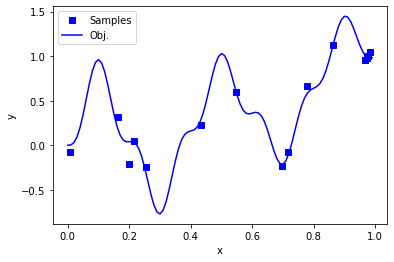

In [2]:
# objective function
def objective(xv, sigma=0.1):
    yv = xv**2 + np.exp(-0.5*xv) * np.sin(5 * np.pi * xv)**(3)
    if sigma != 0:
        noise = np.random.normal(loc=0, scale=sigma, size=xv.shape)
        yv += noise
    return(yv)

np.random.seed(4)
# grid-based sample of the domain [0,1]
xobj = np.arange(0, 1, 0.01).reshape(-1,1) # axis for objective
yobj = objective(xobj, 0) # evaluate objective
xv = np.random.uniform(size=(15,1)) # sample data points
yv = objective(xv) # noise objective at sample points
# find best result
ix = np.argmin(yobj)
print('Minima: x=%.3f, y=%.3f' % (xobj[ix], yobj[ix]))
# plot the points with noise
plt.plot(xv, yv, 'bs', ms=6, label='Samples')
# plot the points without noise
plt.plot(xobj, yobj, 'b-', label='Obj.')
# show labels
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# show the plot
plt.show()

# Gaussian process fitting

In this tutorial, we will use the publically avaliable [GPy library](https://gpy.readthedocs.io/en/deploy/) to fit GPs as well as to make inference. Note that the underlaying computations are covered by my general tutorial on [Gaussian process regression](https://github.com/SebastianGlavind/PhD-study/blob/master/Gaussian-processes/GPR.ipynb).

## Helper functions

In [3]:
# plotting function
def plot_pos(Xtr, ytr, Xte, yte, mu_pos, std_pos):
    plt.plot(Xtr, ytr, 'bs', ms=6, label='Samples')
    plt.plot(Xte, yte, 'b-', ms=3, label='Obj.');
#     plt.plot(Xte, f_samps);
    plt.fill_between(x=Xte[:,0], y1=mu_pos[:,0]-2*std_pos[:,0], y2=mu_pos[:,0]+2*std_pos[:,0], alpha=0.1, color='red');
    plt.plot(Xte, mu_pos, 'r--', lw=2)
    plt.xlabel('x');
    plt.ylabel('f, y');
    plt.axis([0, 1, -1, 2]);
    plt.legend()
    plt.title('GP posterior along with the sample data and the objective');
    # plt.show()

## GP fitting

In [4]:
# Make a GP regression model
np.random.seed(42)
model = GPy.models.GPRegression(xv,yv); # define model
model.optimize_restarts(num_restarts = 10, robust=True, verbose=True); # optimize (Maximum likelihood)
display(model); # display resulting model

Optimization restart 1/10, f = 8.61283210891326
Optimization restart 2/10, f = 8.612832109207016
Optimization restart 3/10, f = 8.612832108929055
Optimization restart 4/10, f = 8.612832108912647
Optimization restart 5/10, f = 8.61283210891094
Optimization restart 6/10, f = 4.319240826836346
Optimization restart 7/10, f = 8.612832108910872
Optimization restart 8/10, f = 4.319240826836138
Optimization restart 9/10, f = 8.612832108915766
Optimization restart 10/10, f = 8.612832108916978


GP_regression.,value,constraints,priors
rbf.variance,0.3210093498682928,+ve,
rbf.lengthscale,0.09402162618462226,+ve,
Gaussian_noise.variance,0.016144110031133446,+ve,


## Plot GP

Parameter estimates:  [0.12705947 0.56657687 0.09402163]


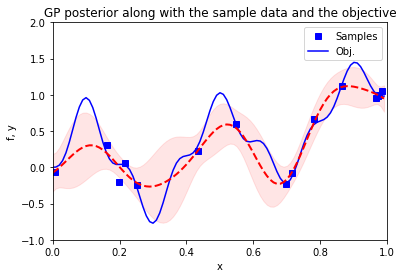

In [5]:
# Parameter estimates
sig_y, sig_f, l_f = np.sqrt(model.Gaussian_noise.variance[0]), np.sqrt(model.rbf.variance[0]), model.rbf.lengthscale[0]
print( 'Parameter estimates: ', np.array([sig_y, sig_f, l_f]) )
# Evaluate posterior
# mu_pos, std_pos = compute_pos1(xv, yv, xobj, sig_y, sig_f, l_f)
# mu_pos, var_pos = model.predict(xobj)
mu_pos, var_pos = model.predict_noiseless(xobj)
std_pos = np.sqrt(var_pos)
# plot posterior
plot_pos(xv, yv, xobj, yobj, mu_pos, std_pos)

# Acquisition (utility) function evaluation

When the observations are noisy, it is recommended best practice to set $f_{min}^{(t)} = \min f_{\star}(\mathbf{x})$ as well as to use the predictive distribution for the latent function $f(\mathbf{x})$ rather than the noisy function $y(\mathbf{x})$ when evaluation the aquisition function, as the (epistemic) uncertainty on this function approaches zero as $N \rightarrow \infty$, see Gramacy (2020), sec. 7.2.4.

## Helper functions

In [6]:
# Probability of improvement, see Gramacy (2020), sec. 7.2
def aPI(mu, sig, fmin, eps=1e-8):
    z = (fmin - mu) / (sig + eps)
    api = stats.norm.cdf( z )   
    return(api)
# Expected improvement, see Gramacy (2020), sec. 7.2
def aEI(mu, sig, fmin, eps=1e-8):
    z = (fmin - mu)/ (sig + eps)
    aei = (fmin - mu)*stats.norm.cdf( z ) + sig*stats.norm.pdf( z )
    return(aei)
# Lower confidence bound
def aLCB(mu, sig, kappa=2):
    alcb = - mu + kappa * sig
    return( alcb )

## Mazimizing the acquisition function

For maximizing the acquisition function, we may employ simple search strategies, such as random sample or grid-based sample, but in general software applications, it is more common to use a local search strategy, such as the BFGS algorithm. In this tutorial, we will use a simple grid sampling strategy.

In [7]:
fmin0 = np.min(mu_pos)
# Probability of improvement, see Gramacy (2020), sec. 7.2
print('PI proposal:  ', xobj[np.argmax(aPI(mu_pos, std_pos, fmin0))])
# Expected improvement, see Gramacy (2020), sec. 7.2
xnew0 = xobj[np.argmax(aEI(mu_pos, std_pos, fmin0))]
print('EI proposal:  ', xnew0)
# Lower confidence bound
print('LCB proposal: ', xobj[np.argmax(aLCB(mu_pos, std_pos))])

PI proposal:   [0.29]
EI proposal:   [0.32]
LCB proposal:  [0.33]


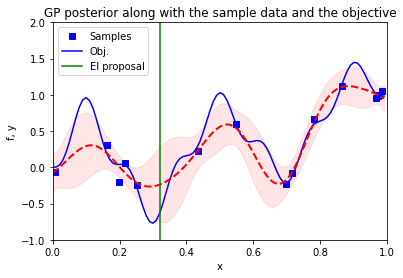

In [8]:
plot_pos(xv, yv, xobj, yobj, mu_pos, std_pos)
plt.plot([xnew0,xnew0], [-1,2], 'g-', label='EI proposal')
plt.legend()
plt.show()

# Bayesian optimization - Maximum likelihood inference

## Optimization

In [9]:
Tsamp = 25
eps = 1e-8
xsamp = xv.copy()
ysamp = yv.copy()
fmin_vec = np.zeros((Tsamp,1))
np.random.seed(42)
for t in range(Tsamp):
    # GP fitting/updating
    gpm = GPy.models.GPRegression(xsamp,ysamp); # define model
#     gpm.optimize_restarts(num_restarts = 10, robust=True, verbose=False); # optimize
    gpm.optimize('lbfgs'); # optimize (Maximum likelihood)
    # Predictions
    mu_pos_i, var_pos_i = gpm.predict_noiseless(xobj)
    std_pos_i = np.sqrt(var_pos_i + eps)
#     del(gpm)
    # Acquisition
    fsamp_min = min(mu_pos_i)
    xnew_i = xobj[np.argmax(aEI(mu_pos_i, std_pos_i, fsamp_min))].reshape(-1,1)
    ynew_i = objective(xnew_i)
    # Book keeping
    xsamp = np.concatenate((xsamp, xnew_i))
    ysamp = np.concatenate((ysamp, ynew_i))
    fmin_vec[t] = fsamp_min

## Plot results

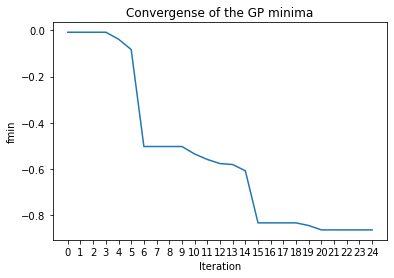

In [10]:
# Convergence
plt.plot(np.minimum.accumulate(fmin_vec))
plt.title('Convergense of the GP minima')
plt.xticks(list(range(Tsamp)), list(range(Tsamp)) )
plt.xlabel('Iteration')
plt.ylabel('fmin')
plt.show()

Grid minima: x=0.300, y=-0.771
GP minima:   x=0.300, y=-0.813


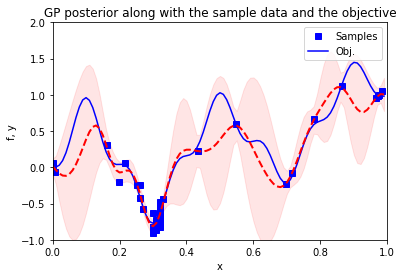

In [11]:
# Surrogate minima
ix_ = (mu_pos_i==fsamp_min)
print('Grid minima: x=%.3f, y=%.3f' % (xobj[ix], yobj[ix]))
print('GP minima:   x=%.3f, y=%.3f' % (xobj[ix_], mu_pos_i[ix_]))

plot_pos(xsamp, ysamp, xobj, yobj, mu_pos_i, std_pos_i)

# Bayesian optimization - Bayesian inference

## Helper functions

In [95]:
# Build model and draw samples from parameter posterior
def BuildMdl_pamPosSamp(x, y, n_psamp=200):
    model = GPy.models.GPRegression(x,y); # define model
    hmc_inf = GPy.inference.mcmc.HMC(model) # Bayesian inference for GP model parameters
    # hmc_samp = hmc.sample(num_samples=1000)[500:]
    pam_samp = hmc_inf.sample(num_samples=n_psamp)[n_psamp//2:] # sampling and disregard burn-in
    return(model, pam_samp)
    
# sampling from posterior for latent function, f
def f_pos_sampling(model, pam_samp, n_fsamp=10):
    for i in range(pam_samp.shape[0]):
        # set parameters to sample i
        model.kern.variance[:] = pam_samp[i,0]
        model.kern.lengthscale[:] = pam_samp[i,1]
        model.likelihood.variance[:] = pam_samp[i,2]
        # draw 10 realizations from model
        pos_f_samp_i = model.posterior_samples_f(xobj, full_cov=True, size=n_fsamp)[:,0,:]
        if i==0:
            pos_samples_hmc = pos_f_samp_i
        else:
            pos_samples_hmc = np.hstack([pos_samples_hmc, pos_f_samp_i])
    return(pos_samples_hmc)

## Optimization

In [109]:
Tsamp = 10
eps = 1e-8
xsamp = xv.copy()
ysamp = yv.copy()
fmin_vec = np.zeros((Tsamp,1))
np.random.seed(42)
for t in range(Tsamp):
    print('iteration', t)
    # GP fitting/updating
    model_hmc_i, hmc_samp_i = BuildMdl_pamPosSamp(xsamp,ysamp) # Bayesian inference for model parameters
    # Sampling and sample statistics
    pos_samples_hmc_i = f_pos_sampling(model_hmc_i, hmc_samp_i) # sample from GP posterior
    mu_pos_i = np.mean(pos_samples_hmc_i, axis=1)
    std_pos_i = np.std(pos_samples_hmc_i, axis=1)
#     del(model_hmc_i)
    # Acquisition
    fsamp_min = min(mu_pos_i)
    xnew_i = xobj[np.argmax(aEI(mu_pos_i, std_pos_i, fsamp_min))].reshape(-1,1)
    ynew_i = objective(xnew_i)
    # Book keeping
    xsamp = np.concatenate((xsamp, xnew_i))
    ysamp = np.concatenate((ysamp, ynew_i))
    fmin_vec[t] = fsamp_min

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


## Plot results

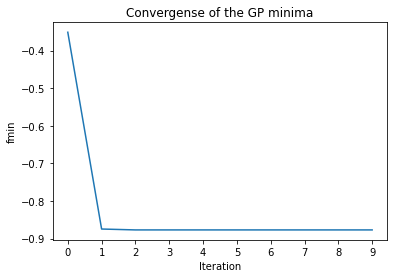

In [110]:
# Convergence
plt.plot(np.minimum.accumulate(fmin_vec))
plt.title('Convergense of the GP minima')
plt.xticks(list(range(Tsamp)), list(range(Tsamp)) )
plt.xlabel('Iteration')
plt.ylabel('fmin')
plt.show()

Grid minima: x=0.300, y=-0.771
GP minima:   x=0.300, y=-0.812


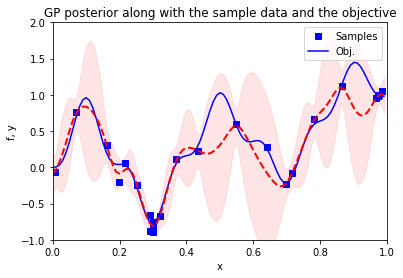

In [111]:
# Surrogate minima
ix_ = (mu_pos_i==fsamp_min)
print('Grid minima: x=%.3f, y=%.3f' % (xobj[ix], yobj[ix]))
print('GP minima:   x=%.3f, y=%.3f' % (xobj[ix_], mu_pos_i[ix_]))

plot_pos(xsamp, ysamp, xobj, yobj, mu_pos_i.reshape(-1,1), std_pos_i.reshape(-1,1))